In [1]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
df = pd.read_csv("jpm_daily_close.csv",index_col=0)
df=df.dropna().reset_index(drop=True)
price = df[['price']]
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3242 entries, 0 to 3241
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   3242 non-null   float64
dtypes: float64(1)
memory usage: 25.5 KB


In [2]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price['price'] = scaler.fit_transform(price['price'].values.reshape(-1,1))

c:\users\brian\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [3]:
def torch_data(stock, lookback):
  original_data = stock.to_numpy()
  data = []

  for index in range(len(original_data) - lookback): 
      data.append(original_data[index: index + lookback])

  data = np.array(data);
  test_set_size = int(np.round(0.2*data.shape[0]));
  train_set_size = data.shape[0] - (test_set_size);

  x_train = data[:train_set_size,:-1,:]
  y_train = data[:train_set_size,-1,:]

  x_test = data[train_set_size:,:-1]
  y_test = data[train_set_size:,-1,:]

  x_train = torch.from_numpy(x_train).type(torch.Tensor)
  x_test = torch.from_numpy(x_test).type(torch.Tensor)
  y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
  y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
  
  return [x_train, y_train_lstm, x_test, y_test_lstm]

lookback = 20
x_train, y_train_lstm, x_test, y_test_lstm = torch_data(price, lookback)

In [4]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
    super(LSTM, self).__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers

    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)    
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
    out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
    out = self.fc(out[:, -1, :]) 
    return out

In [5]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 50

In [6]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
#TODO add train loss + MSE

In [7]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
  y_train_pred = model(x_train)    
  loss = criterion(y_train_pred, y_train_lstm)
  print("Epoch ", t, "MSE: ", loss.item())
  hist[t] = loss.item()    
  optimiser.zero_grad()
  loss.backward()
  optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.33619213104248047
Epoch  1 MSE:  0.23307667672634125
Epoch  2 MSE:  0.15540991723537445
Epoch  3 MSE:  0.15416854619979858
Epoch  4 MSE:  0.13008950650691986
Epoch  5 MSE:  0.10292639583349228
Epoch  6 MSE:  0.09196969121694565
Epoch  7 MSE:  0.07259293645620346
Epoch  8 MSE:  0.03835637494921684
Epoch  9 MSE:  0.05610426887869835
Epoch  10 MSE:  0.026827452704310417
Epoch  11 MSE:  0.026770468801259995
Epoch  12 MSE:  0.03679914027452469
Epoch  13 MSE:  0.026063941419124603
Epoch  14 MSE:  0.017108356580138206
Epoch  15 MSE:  0.018187284469604492
Epoch  16 MSE:  0.0181632898747921
Epoch  17 MSE:  0.012523924931883812
Epoch  18 MSE:  0.007645809091627598
Epoch  19 MSE:  0.007455609273165464
Epoch  20 MSE:  0.009885978884994984
Epoch  21 MSE:  0.011769494041800499
Epoch  22 MSE:  0.011804886162281036
Epoch  23 MSE:  0.01063474640250206
Epoch  24 MSE:  0.00957148801535368
Epoch  25 MSE:  0.009066912345588207
Epoch  26 MSE:  0.008364427834749222
Epoch  27 MSE:  0.00670560

In [8]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

c:\users\brian\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


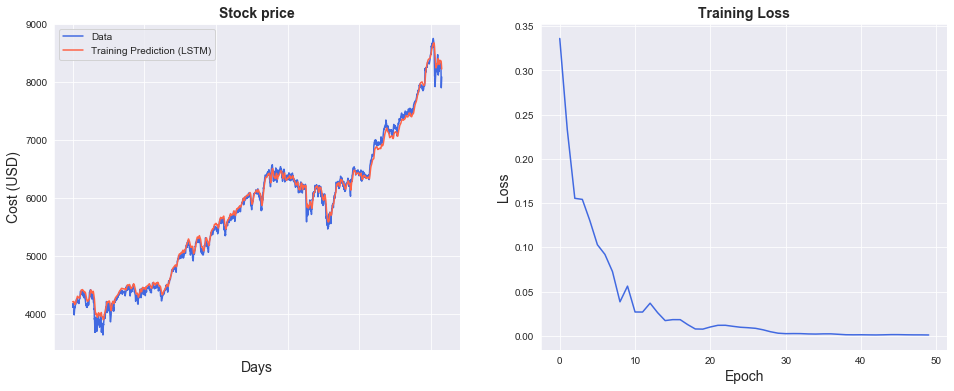

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [10]:
import math, time
from sklearn.metrics import mean_squared_error

y_test_pred = model(x_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())


trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 83.69 RMSE
Test Score: 160.34 RMSE


In [11]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['price'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

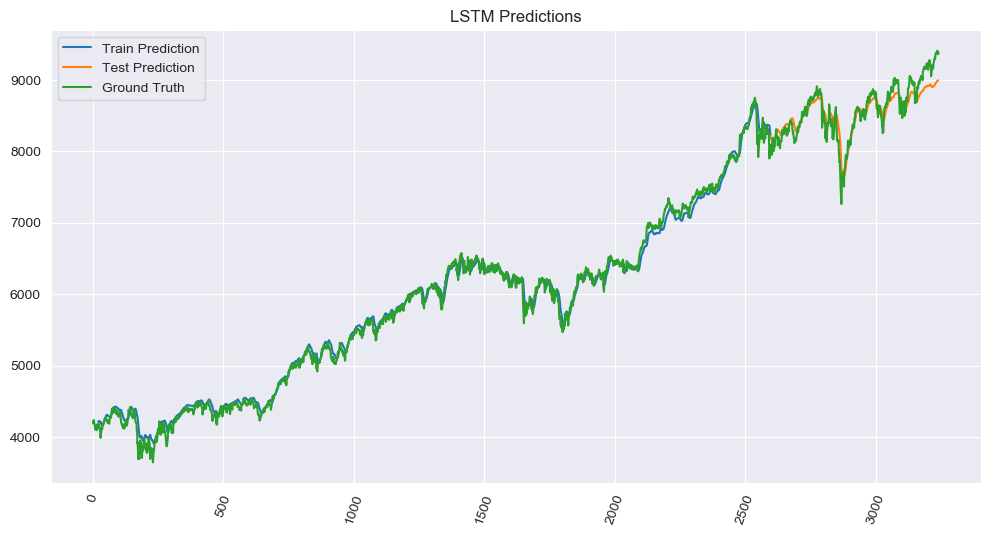

In [12]:
plt.figure(figsize=(12, 6), dpi=100)

for i, col in enumerate(result.columns):
  result[col].plot()

plt.title('LSTM Predictions')

plt.xticks(rotation=70)
plt.legend(['Train Prediction', 'Test Prediction', 'Ground Truth'])